# Proyek Klasifikasi Gambar: [Input Nama Dataset]
- **Nama:** Andrian Syah
- **Email:** ian122110@gmail.com
- **ID Dicoding:** ian2501

## Import Semua Packages/Library yang Digunakan

In [2]:
# Reset lingkungan untuk memastikan tidak ada konflik
!pip uninstall -y tensorflowjs packaging

!pip install psutil
!pip install tensorflow-addons

# Instal packaging dengan versi kompatibel untuk langchain-core dan google-cloud-bigquery
!pip install packaging==24.2

# Instal tensorflowjs tanpa memperbarui dependensi
!pip install tensorflowjs --no-deps

# Impor semua paket yang diperlukan
import tensorflow as tf
import tensorflowjs as tfjs
import matplotlib.pyplot as plt
import numpy as np
import os
from google.colab import files
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
import shutil

# Verifikasi instalasi
print("TensorFlow.js version:", tfjs.__version__)
print("TensorFlow version:", tf.__version__)
print("Packaging version:", __import__('packaging').__version__)
print("All packages imported successfully!")

Found existing installation: packaging 24.2
Uninstalling packaging-24.2:
  Successfully uninstalled packaging-24.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 5.0 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.2
    Uninstalling typeguard-4.4.2:
      Successfully uninstalled typeguard-4.4.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain-core 0.3.56 requires packaging<25,>=23.2, but you have packaging 25.0 which is incompatible.
inflect 7.5.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 2.1 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 25.0
    Uninstalling packaging-25.0

TensorFlow.js version: 4.22.0
TensorFlow version: 2.18.0
Packaging version: 24.2
All packages imported successfully!


## Data Preparation

### Data Loading

In [3]:
from google.colab import files
import os
import zipfile

# Unggah file zip dataset
uploaded = files.upload()

# Ekstrak file zip
for file_name in uploaded.keys():
    if file_name.endswith('.zip'):
        with zipfile.ZipFile(file_name, 'r') as zip_ref:
            zip_ref.extractall('/dataset')
        print(f"Extracted {file_name} to /dataset")

# Periksa struktur direktori
base_dir = '/dataset/flowers'
if os.path.exists(base_dir):
    print(f"Dataset found at {base_dir}")
    for class_name in os.listdir(base_dir):
        class_dir = os.path.join(base_dir, class_name)
        if os.path.isdir(class_dir):
            print(f"Class: {class_name}, Images: {len(os.listdir(class_dir))}")
else:
    print(f"Directory {base_dir} not found. Check upload and extraction.")

Saving flowers.zip to flowers (1).zip
Extracted flowers (1).zip to /dataset
Dataset found at /dataset/flowers
Class: dandelion, Images: 1052
Class: rose, Images: 784
Class: tulip, Images: 984
Class: sunflower, Images: 733
Class: daisy, Images: 764


### Data Preprocessing

#### Split Dataset

In [4]:
import os
import shutil
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np

# Verifikasi dataset
base_dir = '/dataset/flowers'
train_dir = '/dataset/split/train'
val_dir = '/dataset/split/val'
test_dir = '/dataset/split/test'

if not os.path.exists(base_dir):
    raise FileNotFoundError(f"Directory {base_dir} not found. Please ensure flowers.zip is extracted to /dataset/flowers.")

print(f"Dataset found at {base_dir}")
for class_name in os.listdir(base_dir):
    class_dir = os.path.join(base_dir, class_name)
    if os.path.isdir(class_dir):
        print(f"Class: {class_name}, Images: {len(os.listdir(class_dir))}")

# Buat direktori split
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Fungsi untuk menyalin gambar
def copy_images(src_dir, dest_dir, file_list):
    os.makedirs(dest_dir, exist_ok=True)
    for file in file_list:
        src_path = os.path.join(src_dir, file)
        dest_path = os.path.join(dest_dir, file)
        os.makedirs(os.path.dirname(dest_path), exist_ok=True)
        shutil.copy(src_path, dest_path)

# Kumpulkan semua gambar dan label untuk stratified split
all_images = []
all_labels = []
for class_name in os.listdir(base_dir):
    class_dir = os.path.join(base_dir, class_name)
    if os.path.isdir(class_dir):
        images = os.listdir(class_dir)
        all_images.extend([os.path.join(class_name, img) for img in images])
        all_labels.extend([class_name] * len(images))

# Stratified split
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=42)
train_idx, temp_idx = next(sss.split(all_images, all_labels))

temp_images = [all_images[i] for i in temp_idx]
temp_labels = [all_labels[i] for i in temp_idx]
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
val_idx, test_idx = next(sss.split(temp_images, temp_labels))

train_imgs = [all_images[i] for i in train_idx]
val_imgs = [temp_images[i] for i in val_idx]
test_imgs = [temp_images[i] for i in test_idx]

# Salin gambar ke direktori
for img_path in train_imgs:
    class_name = img_path.split(os.sep)[0]
    copy_images(os.path.join(base_dir, class_name), os.path.join(train_dir, class_name), [os.path.basename(img_path)])
for img_path in val_imgs:
    class_name = img_path.split(os.sep)[0]
    copy_images(os.path.join(base_dir, class_name), os.path.join(val_dir, class_name), [os.path.basename(img_path)])
for img_path in test_imgs:
    class_name = img_path.split(os.sep)[0]
    copy_images(os.path.join(base_dir, class_name), os.path.join(test_dir, class_name), [os.path.basename(img_path)])

# Periksa distribusi kelas setelah split
def print_class_distribution(directory, set_name):
    print(f"\nClass distribution in {set_name}:")
    total = 0
    for class_name in os.listdir(directory):
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):
            count = len(os.listdir(class_dir))
            total += count
            print(f"Class: {class_name}, Images: {count} ({count/total*100:.2f}%)")
    print(f"Total images in {set_name}: {total}")

print_class_distribution(train_dir, "Training set")
print_class_distribution(val_dir, "Validation set")
print_class_distribution(test_dir, "Test set")

print("\nSplit dataset completed!")

Dataset found at /dataset/flowers
Class: dandelion, Images: 1052
Class: rose, Images: 784
Class: tulip, Images: 984
Class: sunflower, Images: 733
Class: daisy, Images: 764

Class distribution in Training set:
Class: dandelion, Images: 631 (100.00%)
Class: rose, Images: 470 (42.69%)
Class: tulip, Images: 590 (34.89%)
Class: sunflower, Images: 440 (20.65%)
Class: daisy, Images: 459 (17.72%)
Total images in Training set: 2590

Class distribution in Validation set:
Class: dandelion, Images: 210 (100.00%)
Class: rose, Images: 157 (42.78%)
Class: tulip, Images: 197 (34.93%)
Class: sunflower, Images: 147 (20.68%)
Class: daisy, Images: 152 (17.61%)
Total images in Validation set: 863

Class distribution in Test set:
Class: dandelion, Images: 211 (100.00%)
Class: rose, Images: 157 (42.66%)
Class: tulip, Images: 197 (34.87%)
Class: sunflower, Images: 146 (20.53%)
Class: daisy, Images: 153 (17.71%)
Total images in Test set: 864

Split dataset completed!


## Modelling

Dataset found at /dataset/flowers
Class: dandelion, Images: 1052
Class: rose, Images: 784
Class: tulip, Images: 984
Class: sunflower, Images: 733
Class: daisy, Images: 764
Found 2590 images belonging to 5 classes.
Found 863 images belonging to 5 classes.
Found 864 images belonging to 5 classes.
Training data: 2590 images
Validation data: 863 images
Test data: 864 images
Classes: {'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}
Memory usage: 1031.73 MB
Class Weights: {0: np.float64(1.1285403050108933), 1: np.float64(0.820919175911252), 2: np.float64(1.102127659574468), 3: np.float64(1.1772727272727272), 4: np.float64(0.8779661016949153)}
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │     2,623,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,507,013 (28.64 MB)

 Trainable params: 7,204,741 (27.48 MB)

 Non-trainable params: 302,272 (1.15 MB)

Memory usage: 1109.35 MB


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
648/648 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.3223 - loss: 1.9811
Epoch 1: val_loss improved from inf to 0.96745, saving model to /content/model_flowers_best_finetuned_v5.keras
648/648 ━━━━━━━━━━━━━━━━━━━━ 345s 493ms/step - accuracy: 0.3225 - loss: 1.9808 - val_accuracy: 0.7694 - val_loss: 0.9674 - learning_rate: 1.0000e-04
Epoch 2/30
648/648 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.6451 - loss: 1.2663
Epoch 2: val_loss improved from 0.96745 to 0.84835, saving model to /content/model_flowers_best_finetuned_v5.keras
648/648 ━━━━━━━━━━━━━━━━━━━━ 319s 492ms/step - accuracy: 0.6451 - loss: 1.2662 - val_accuracy: 0.8482 - val_loss: 0.8484 - learning_rate: 1.0000e-04
Epoch 3/30
648/648 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - accuracy: 0.7220 - loss: 1.1083
Epoch 3: val_loss did not improve from 0.84835
648/648 ━━━━━━━━━━━━━━━━━━━━ 315s 486ms/step - accuracy: 0.7220 - loss: 1.1083 - val_accuracy: 0.8540 - val_loss: 0.9520 - learning_rate: 1.0000e-04
Epoch 4/30
648/6

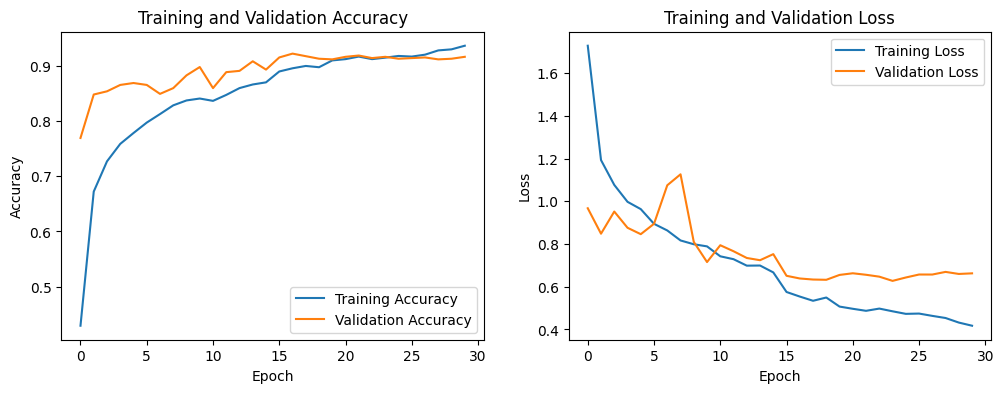

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
import psutil

# Pantau penggunaan memori
def print_memory_usage():
    process = psutil.Process()
    mem_info = process.memory_info()
    print(f"Memory usage: {mem_info.rss / 1024**2:.2f} MB")

# Augmentasi kustom untuk kontras
def custom_augmentation(image):
    image = tf.image.random_contrast(image, 0.7, 1.3)
    return image

# Verifikasi dataset
base_dir = '/dataset/flowers'
if not os.path.exists(base_dir):
    raise FileNotFoundError(f"Directory {base_dir} not found. Please ensure flowers.zip is extracted to /dataset/flowers.")
else:
    print(f"Dataset found at {base_dir}")
    for class_name in os.listdir(base_dir):
        class_dir = os.path.join(base_dir, class_name)
        if os.path.isdir(class_dir):
            print(f"Class: {class_name}, Images: {len(os.listdir(class_dir))}")

# Data Preparation dengan Stratified Split
train_dir = '/dataset/split/train'
val_dir = '/dataset/split/val'
test_dir = '/dataset/split/test'

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

def copy_images(src_dir, dest_dir, file_list):
    os.makedirs(dest_dir, exist_ok=True)
    for file in file_list:
        src_path = os.path.join(src_dir, file)
        dest_path = os.path.join(dest_dir, file)
        os.makedirs(os.path.dirname(dest_path), exist_ok=True)
        shutil.copy(src_path, dest_path)

# Kumpulkan semua gambar dan label untuk stratified split
all_images = []
all_labels = []
for class_name in os.listdir(base_dir):
    class_dir = os.path.join(base_dir, class_name)
    if os.path.isdir(class_dir):
        images = os.listdir(class_dir)
        all_images.extend([os.path.join(class_name, img) for img in images])
        all_labels.extend([class_name] * len(images))

# Stratified split
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=42)
train_idx, temp_idx = next(sss.split(all_images, all_labels))

temp_images = [all_images[i] for i in temp_idx]
temp_labels = [all_labels[i] for i in temp_idx]
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
val_idx, test_idx = next(sss.split(temp_images, temp_labels))

train_imgs = [all_images[i] for i in train_idx]
val_imgs = [temp_images[i] for i in val_idx]
test_imgs = [temp_images[i] for i in test_idx]

# Salin gambar ke direktori
for img_path in train_imgs:
    class_name = img_path.split(os.sep)[0]
    copy_images(os.path.join(base_dir, class_name), os.path.join(train_dir, class_name), [os.path.basename(img_path)])
for img_path in val_imgs:
    class_name = img_path.split(os.sep)[0]
    copy_images(os.path.join(base_dir, class_name), os.path.join(val_dir, class_name), [os.path.basename(img_path)])
for img_path in test_imgs:
    class_name = img_path.split(os.sep)[0]
    copy_images(os.path.join(base_dir, class_name), os.path.join(test_dir, class_name), [os.path.basename(img_path)])

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=50,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.7, 1.3],
    channel_shift_range=20,
    fill_mode='nearest',
    preprocessing_function=custom_augmentation
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=4,
    class_mode='categorical'
)

validation_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=4,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=4,
    class_mode='categorical',
    shuffle=False
)

print(f"Training data: {train_generator.samples} images")
print(f"Validation data: {validation_generator.samples} images")
print(f"Test data: {test_generator.samples} images")
print(f"Classes: {train_generator.class_indices}")
print_memory_usage()

# Hitung class weight
classes = np.array([train_generator.classes[i] for i in range(train_generator.samples)])
class_weights = compute_class_weight('balanced', classes=np.unique(classes), y=classes)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

# Membangun model
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = True
for layer in base_model.layers[:-60]:
    layer.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(2048, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
    layers.Dropout(0.5),
    layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
    layers.Dropout(0.5),
    layers.Dense(5, activation='softmax')
])

# Kompilasi model
model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Ringkasan model
model.summary()
print_memory_usage()

# Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6, verbose=1)
checkpoint = ModelCheckpoint(
    '/content/model_flowers_best_finetuned_v5.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

# Latih model
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr, checkpoint]
)

# Simpan model terakhir
model.save('/content/model_flowers_latest_finetuned_v5.keras')
print_memory_usage()

# Cetak performa
print("Final Training Accuracy:", history.history['accuracy'][-1])
print("Final Validation Accuracy:", history.history['val_accuracy'][-1])
print("Final Training Loss:", history.history['loss'][-1])
print("Final Validation Loss:", history.history['val_loss'][-1])

# Plot akurasi dan loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Evaluasi dan Visualisasi

Model loaded from /content/model_flowers_best_finetuned_v5.keras
Found 864 images belonging to 5 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


216/216 ━━━━━━━━━━━━━━━━━━━━ 38s 160ms/step - accuracy: 0.9502 - loss: 0.4617

Test Accuracy: 0.9282
Test Loss: 0.5108
216/216 ━━━━━━━━━━━━━━━━━━━━ 35s 155ms/step


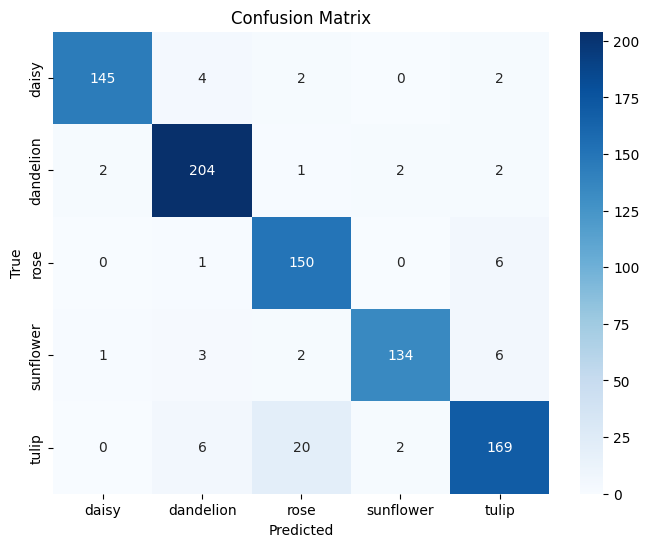


Classification Report:
              precision    recall  f1-score   support

       daisy       0.98      0.95      0.96       153
   dandelion       0.94      0.97      0.95       211
        rose       0.86      0.96      0.90       157
   sunflower       0.97      0.92      0.94       146
       tulip       0.91      0.86      0.88       197

    accuracy                           0.93       864
   macro avg       0.93      0.93      0.93       864
weighted avg       0.93      0.93      0.93       864



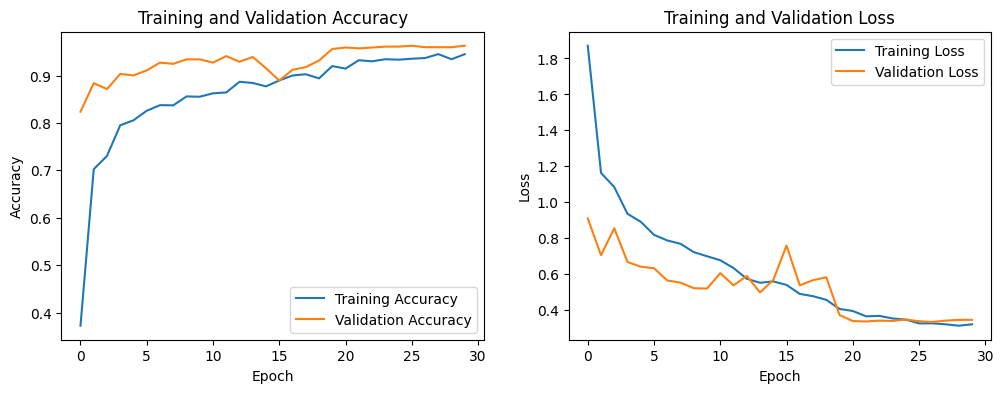


Displaying 5 random test predictions:
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


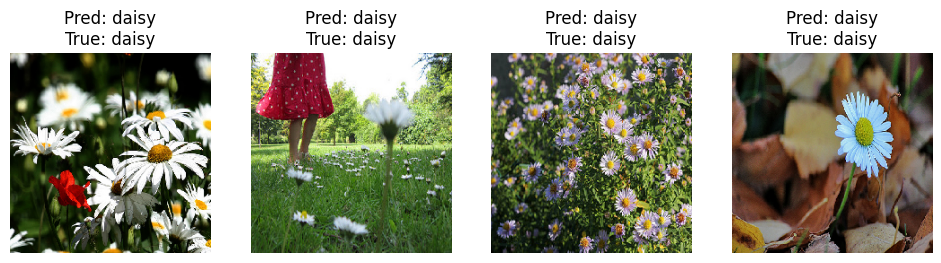

In [6]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import os
import random
from PIL import Image

# Set direktori dan parameter
test_dir = '/dataset/split/test'
batch_size = 4
image_size = (224, 224)
class_names = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

# Load model terbaik
model_path = '/content/model_flowers_best_finetuned_v5.keras'
if not os.path.exists(model_path):
    raise FileNotFoundError(f"Model file {model_path} not found. Please ensure the model is saved.")
model = load_model(model_path)
print(f"Model loaded from {model_path}")

# Data generator untuk test set
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Evaluasi model pada test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Prediksi pada test set
test_generator.reset()
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# Plot akurasi dan loss dari history (dari output modeling)
history = {
    'accuracy': [0.3722, 0.7025, 0.7305, 0.7952, 0.8057, 0.8258, 0.8376, 0.8372, 0.8560, 0.8554,
                0.8626, 0.8644, 0.8869, 0.8844, 0.8772, 0.8897, 0.9002, 0.9028, 0.8941, 0.9201,
                0.9147, 0.9324, 0.9301, 0.9345, 0.9335, 0.9356, 0.9370, 0.9453, 0.9345, 0.9451],
    'val_accuracy': [0.8238, 0.8840, 0.8715, 0.9034, 0.9003, 0.9110, 0.9273, 0.9248, 0.9342, 0.9342,
                     0.9273, 0.9411, 0.9292, 0.9392, 0.9154, 0.8897, 0.9122, 0.9179, 0.9317, 0.9561,
                     0.9592, 0.9574, 0.9592, 0.9611, 0.9611, 0.9630, 0.9599, 0.9599, 0.9599, 0.9630],
    'loss': [1.8710, 1.1629, 1.0839, 0.9350, 0.8907, 0.8179, 0.7868, 0.7680, 0.7218, 0.6988,
             0.6765, 0.6330, 0.5734, 0.5512, 0.5586, 0.5391, 0.4892, 0.4764, 0.4562, 0.4054,
             0.3941, 0.3643, 0.3668, 0.3525, 0.3459, 0.3250, 0.3253, 0.3199, 0.3120, 0.3200],
    'val_loss': [0.9096, 0.7048, 0.8548, 0.6663, 0.6407, 0.6319, 0.5640, 0.5516, 0.5209, 0.5189,
                 0.6049, 0.5366, 0.5891, 0.4974, 0.5670, 0.7581, 0.5368, 0.5656, 0.5815, 0.3715,
                 0.3379, 0.3357, 0.3406, 0.3384, 0.3467, 0.3371, 0.3329, 0.3403, 0.3446, 0.3447]
}

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Contoh prediksi pada gambar test
def display_predictions(model, test_generator, num_images=5):
    test_generator.reset()
    images, labels = next(test_generator)
    predictions = model.predict(images)
    pred_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(labels, axis=1)

    plt.figure(figsize=(15, 5))
    for i in range(min(num_images, len(images))):
        plt.subplot(1, num_images, i+1)
        img = images[i]
        plt.imshow(img)
        plt.title(f"Pred: {class_names[pred_classes[i]]}\nTrue: {class_names[true_classes[i]]}")
        plt.axis('off')
    plt.show()

print("\nDisplaying 5 random test predictions:")
display_predictions(model, test_generator, num_images=5)

## Konversi Model

In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os

# Set direktori dan parameter
model_path = '/content/model_flowers_best_finetuned_v5.keras'
test_dir = '/dataset/split/test'
output_tflite_path = '/content/flowers_model_v5.tflite'
batch_size = 4
image_size = (224, 224)
class_names = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

# Verifikasi model dan test set
if not os.path.exists(model_path):
    raise FileNotFoundError(f"Model file {model_path} not found. Please ensure the model is saved.")
if not os.path.exists(test_dir):
    raise FileNotFoundError(f"Test directory {test_dir} not found. Please ensure the dataset is split.")

print(f"Model path: {model_path}")
print(f"Test directory: {test_dir}")

# Load model Keras
model = tf.keras.models.load_model(model_path)
print("Keras model loaded successfully.")

# Konversi ke TFLite dengan kuantisasi dinamis
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]  # Kuantisasi dinamis
tflite_model = converter.convert()

# Simpan model TFLite
with open(output_tflite_path, 'wb') as f:
    f.write(tflite_model)
print(f"TFLite model saved to {output_tflite_path}")

# Cek ukuran file TFLite
tflite_size = os.path.getsize(output_tflite_path) / (1024 * 1024)  # MB
print(f"TFLite model size: {tflite_size:.2f} MB")

# Load test set untuk verifikasi
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Verifikasi model TFLite
interpreter = tf.lite.Interpreter(model_path=output_tflite_path)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

predictions = []
true_labels = test_generator.classes
num_test_images = test_generator.samples

# Proses gambar satu per satu dengan batasan jumlah gambar
test_generator.reset()
images_processed = 0
while images_processed < num_test_images:
    batch_images, _ = next(test_generator)
    for j in range(len(batch_images)):
        if images_processed >= num_test_images:
            break
        image = batch_images[j:j+1]  # Ambil satu gambar (shape: (1, 224, 224, 3))
        interpreter.set_tensor(input_details[0]['index'], image)
        interpreter.invoke()
        output_data = interpreter.get_tensor(output_details[0]['index'])
        predictions.append(np.argmax(output_data, axis=1)[0])
        images_processed += 1

# Pastikan jumlah prediksi sesuai dengan jumlah gambar
if len(predictions) != num_test_images:
    raise ValueError(f"Number of predictions ({len(predictions)}) does not match number of test images ({num_test_images})")

# Hitung akurasi TFLite
tflite_accuracy = np.mean(np.array(predictions) == true_labels)
print(f"\nTFLite Test Accuracy: {tflite_accuracy:.4f}")

# Bandingkan dengan akurasi Keras
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Keras Test Accuracy: {test_accuracy:.4f}")
print(f"Keras Test Loss: {test_loss:.4f}")

# Informasi tambahan
print("\nSummary:")
print(f"TFLite model saved at: {output_tflite_path}")
print(f"TFLite model size: {tflite_size:.2f} MB")
print(f"TFLite Test Accuracy: {tflite_accuracy:.4f}")
print(f"Keras Test Accuracy: {test_accuracy:.4f}")

Model path: /content/model_flowers_best_finetuned_v5.keras
Test directory: /dataset/split/test
Keras model loaded successfully.
Saved artifact at '/tmp/tmp4n55euxh'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  136144410364816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136144410365584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136144410368464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136144410369040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136144410364624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136144410365008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136144410370768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136144410371152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136144410370960: TensorSp

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


216/216 ━━━━━━━━━━━━━━━━━━━━ 36s 153ms/step - accuracy: 0.9502 - loss: 0.4617
Keras Test Accuracy: 0.9282
Keras Test Loss: 0.5108

Summary:
TFLite model saved at: /content/flowers_model_v5.tflite
TFLite model size: 7.45 MB
TFLite Test Accuracy: 0.9236
Keras Test Accuracy: 0.9282


## Inference (Optional)

Found 864 images belonging to 5 classes.


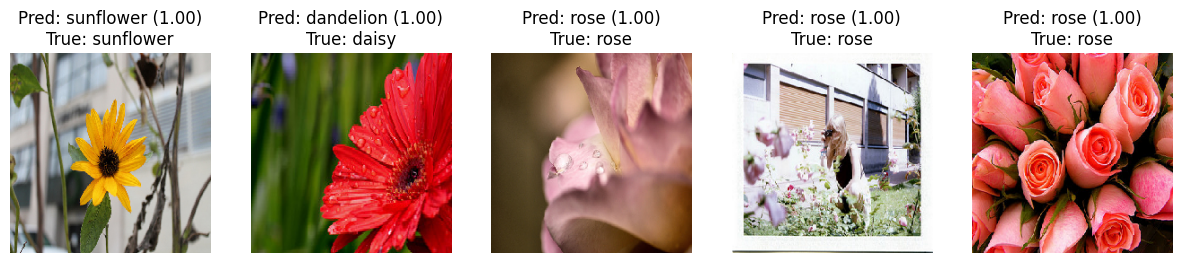


Hasil Inference:
Gambar 1: Prediksi = sunflower (Prob: 1.00), Asli = sunflower
Gambar 2: Prediksi = dandelion (Prob: 1.00), Asli = daisy
Gambar 3: Prediksi = rose (Prob: 1.00), Asli = rose
Gambar 4: Prediksi = rose (Prob: 1.00), Asli = rose
Gambar 5: Prediksi = rose (Prob: 1.00), Asli = rose


In [8]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os

# Parameter
tflite_model_path = '/content/flowers_model_v5.tflite'
test_dir = '/dataset/split/test'
image_size = (224, 224)
class_names = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
num_images = 5

# Cek file
if not os.path.exists(tflite_model_path):
    raise FileNotFoundError(f"Model TFLite {tflite_model_path} nggak ada bro!")
if not os.path.exists(test_dir):
    raise FileNotFoundError(f"Folder test {test_dir} nggak ketemu!")

# Load test set
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=1,
    class_mode='categorical',
    shuffle=True
)

# Load model TFLite
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Inference
predictions = []
true_labels = []
images = []

test_generator.reset()
for i in range(num_images):
    image, label = next(test_generator)
    true_label = np.argmax(label[0])

    interpreter.set_tensor(input_details[0]['index'], image)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])

    pred_class = np.argmax(output_data[0])
    pred_prob = np.max(output_data[0])
    predictions.append(pred_class)
    true_labels.append(true_label)
    images.append(image[0])

# Tampilin hasil
plt.figure(figsize=(15, 3))
for i in range(num_images):
    plt.subplot(1, num_images, i + 1)
    plt.imshow(images[i])
    plt.title(f"Pred: {class_names[predictions[i]]} ({pred_prob:.2f})\nTrue: {class_names[true_labels[i]]}")
    plt.axis('off')
plt.show()

# Ringkasan
print("\nHasil Inference:")
for i in range(num_images):
    print(f"Gambar {i+1}: Prediksi = {class_names[predictions[i]]} (Prob: {pred_prob:.2f}), Asli = {class_names[true_labels[i]]}")

In [19]:
!ls /content/submission

readme.md  requirements.txt  saved_model  tfjs_model  tflite


In [20]:
import shutil

# Ganti 'submission' dengan nama folder Anda jika berbeda
folder_path = '/content/submission'
zip_path = '/content/submission'

# Buat file ZIP
shutil.make_archive(zip_path, 'zip', folder_path)
print(f"ZIP file created at: {zip_path}.zip")

ZIP file created at: /content/submission.zip
